### Code block 1: Package initialization
Import required packages, do not change.

In [1]:
import argparse
import os, sys
import time
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt

# Import pytorch dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.modules.utils import _single, _pair, _triple

### Code block 2: Useful classes
Customized implementation of [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) and [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear), do not change.

In [2]:
class CONV(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1,
                 bias=False, padding_mode='zeros'):
        self.input = None
        self.output = None
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        super(CONV, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation,
            groups, bias, padding_mode)

    def forward(self, input):
        self.input = input
        # 'pytorch 2.0'
        self.output = super().forward(input)
        return self.output

class FC(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        self.input = None
        self.output = None
        super(FC, self).__init__(in_features, out_features, bias)

    def forward(self, input):
        self.input = input
        self.output = F.linear(input, self.weight, self.bias)
        return self.output

## Lab 2

### Code block 3: SimpleNN implementation

Please follow the instructions in Lab 2(a) and fill in the code in the lines marked **Your code here**

In [3]:
"""
Lab 2(a)
Build the SimpleNN model by following Table 1
"""

# Create the neural network module: LeNet-5
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # Layer definition
        self.conv1 = nn.Conv2d(3, 16, 5, stride=1, padding=2) #Your code here
        self.conv2 = nn.Conv2d(16, 16, 3, stride=1, padding=2)    #Your code here
        self.conv3 = nn.Conv2d(16, 32, 7, stride=1, padding=2)    #Your code here
        self.fc1   = nn.Linear(288,32)    #Your code here
        self.fc2   = nn.Linear(32, 10)    #Your code here

        
    def forward(self, x):
        # Forward pass computation
        # Conv 1
        x = nn.functional.relu(self.conv1(x))
        # MaxPool
        x = nn.functional.max_pool2d(x, 4, 2)
        # Conv 2
        x = nn.functional.relu(self.conv2(x))
        # MaxPool
        x = nn.functional.max_pool2d(x, 3, 2)
        # Conv 3
        x = nn.functional.relu(self.conv3(x))
        # MaxPool
        x = nn.functional.max_pool2d(x, 2, 2)
        # Flatten
        x = torch.flatten(x, 1)
        # FC 1
        x = nn.functional.relu(self.fc1(x))
        # FC 2
        x = nn.functional.relu(self.fc2(x))
        return x

# GPU check
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")

# Model Definition
net = SimpleNN()
net = net.to(device)

# Test forward pass
data = torch.randn(5,3,32,32)
data = data.to(device)
# Forward pass "data" through "net" to get output "out"
out = net(data)

# Check output shape
assert(out.detach().cpu().numpy().shape == (5,10))
print("Forward pass successful")

Run on GPU...
Forward pass successful


### Code block 4: Shape observation
Please follow the instructions in Lab 2(a) and fill in the code in the lines marked **Your code here**. Gather the printed results in Table 2 in your report.

In [4]:
"""
Lab 2(b)
"""
# Forward pass of a single image
data = torch.randn(1,3,32,32).to(device)

# Dictionary to store activations inline
activations = {}

# Simple inline hook function
def hook_fn(m, i, o):
    activations[m] = {'input': i[0], 'output': o}

# Register hooks inline
hooks = []
for name, module in net.named_modules():
    if isinstance(module, (nn.Conv2d, nn.Linear)):
        hooks.append(module.register_forward_hook(hook_fn))

# Forward pass "data" through "net" to get output "out"
out = net(data)


for name, module in net.named_modules():
    if isinstance(module, (nn.Conv2d, nn.Linear)):
        input = activations[module]['input'].cuda().detach().cpu().numpy()
        output = activations[module]['output'].cuda().detach().cpu().numpy()
        weight = module.weight.cuda().detach().cpu().numpy()
        num_Param = weight.size
        
        # Calculate MACs
        if isinstance(module, nn.Conv2d):
            _, _, h, w = output.shape
            num_MAC = module.kernel_size[0] * module.kernel_size[1] * module.in_channels * module.out_channels * h * w
        else:  # Linear layer
            num_MAC = module.in_features * module.out_features
            
        print(f'{name:10} {str(input.shape):20} {str(output.shape):20} {str(weight.shape):20} {str(num_Param):10} {str(num_MAC):10}')

# Remove hooks
for hook in hooks:
    hook.remove()

conv1      (1, 3, 32, 32)       (1, 16, 32, 32)      (16, 3, 5, 5)        1200       1228800   
conv2      (1, 16, 15, 15)      (1, 16, 17, 17)      (16, 16, 3, 3)       2304       665856    
conv3      (1, 16, 8, 8)        (1, 32, 6, 6)        (32, 16, 7, 7)       25088      903168    
fc1        (1, 288)             (1, 32)              (32, 288)            9216       9216      
fc2        (1, 32)              (1, 10)              (10, 32)             320        320       


## Lab 3 (Bonus)

### Code block 5: Initial weight histogram
Please follow the instructions in Lab 3(a) and fill in the code in the lines marked **Your code here**. Copy the output figures into your report.

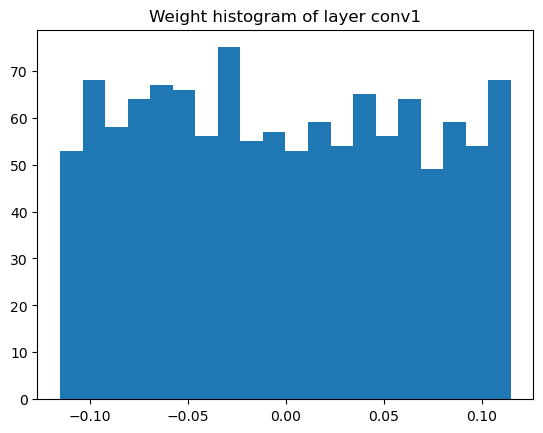

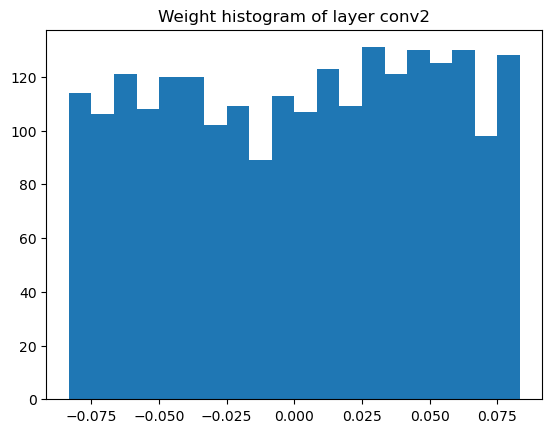

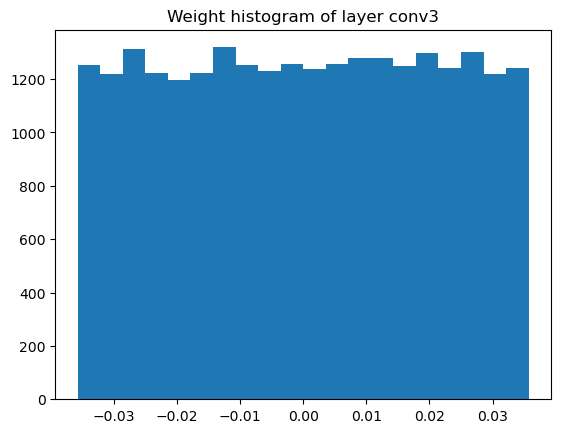

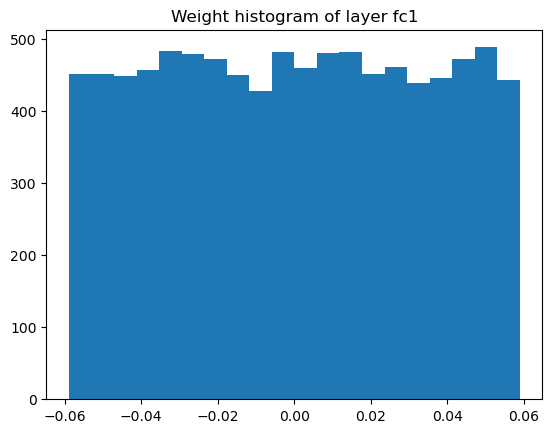

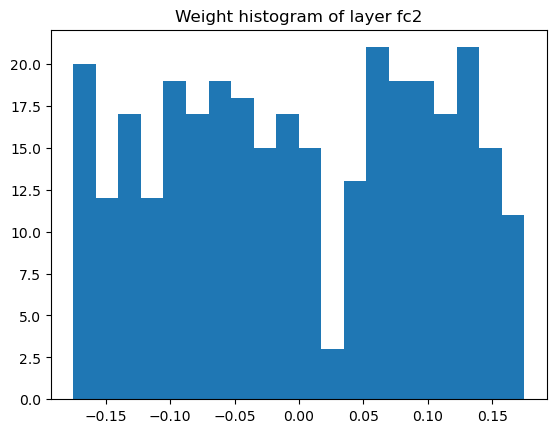

In [5]:
"""
Lab 3(a)
"""
for name, module in net.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        # Get the weight of the module as a NumPy array
        weight = module.weight.detach().cpu().numpy() 

        # Reshape for histogram
        weight = weight.reshape(-1)
        _ = plt.hist(weight, bins=20)
        plt.title("Weight histogram of layer "+name)
        plt.show()

### Code block 6: Gradient histogram
Please follow the instructions in Lab 3(b) and fill in the code in the lines marked **Your code here**. Copy the output figures into your report.

Output type: <class 'torch.Tensor'>
Output shape: torch.Size([1, 10])
 SimpleNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)
conv1 Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))


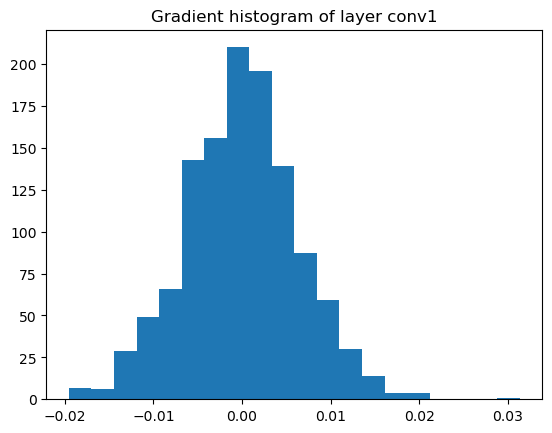

conv2 Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))


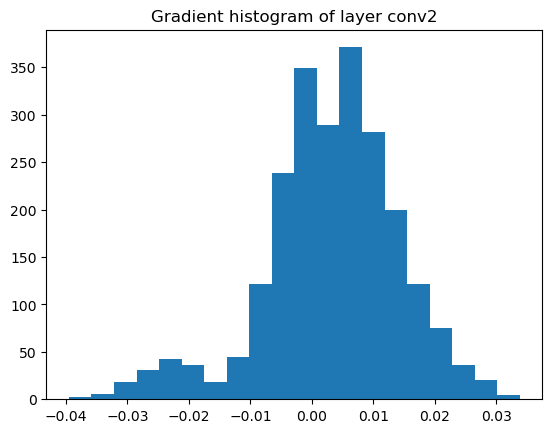

conv3 Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))


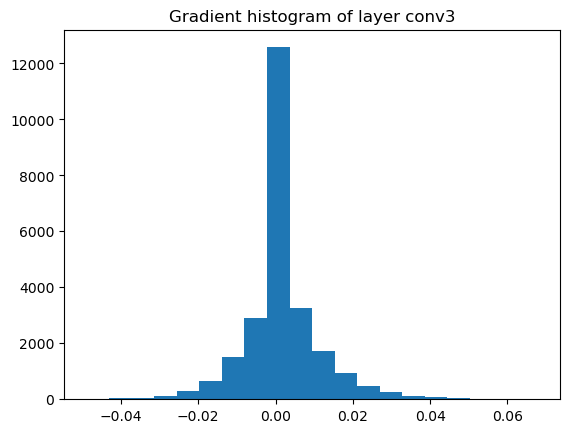

fc1 Linear(in_features=288, out_features=32, bias=True)


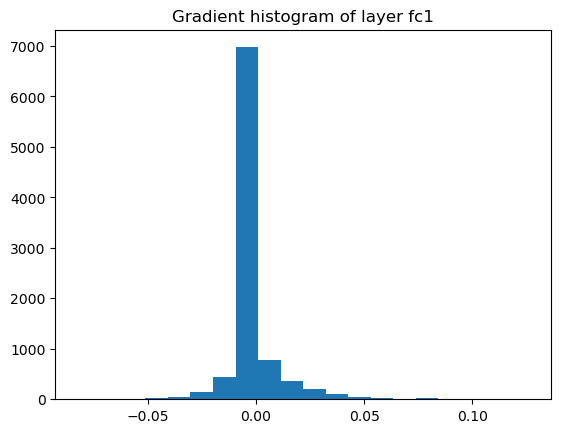

fc2 Linear(in_features=32, out_features=10, bias=True)


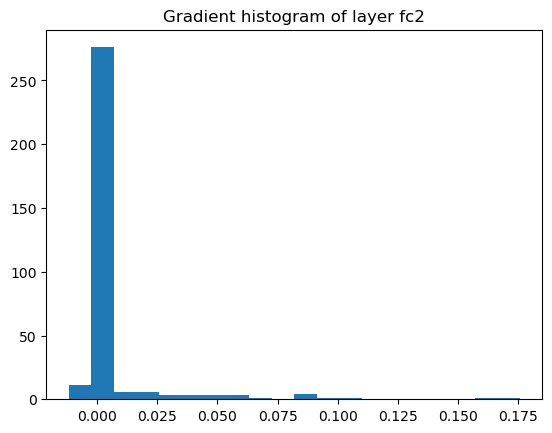

In [6]:
'''
Lab 3(b)
'''
# Loss definition
criterion = nn.MSELoss()

# Forward pass (create output with gradient tracking)
data = data.requires_grad_() # Enable gradient tracking
output = net(data)
print("Output type:", type(output))
print("Output shape:", output.shape)

# Random target
target = torch.randn(1, 10).to(device)

# Loss computation
loss = criterion(output, target)     #Your code here
# Backward pass for gradients
     #Your code here
loss.backward()

for name, module in net.named_modules():
    print(name, module)
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        # Get the gradient of the module as a NumPy array
        gradient = module.weight.grad.detach().cpu().numpy()     #Your code here
        
        # Reshape for histogram
        gradient = gradient.reshape(-1)
        _ = plt.hist(gradient, bins=20)
        plt.title("Gradient histogram of layer "+name)
        plt.show()


### Code block 7: Zero initialization?
Please follow the instructions in Lab 3(c) and fill in the code in the lines marked **Your code here**. Copy the output figures into your report.

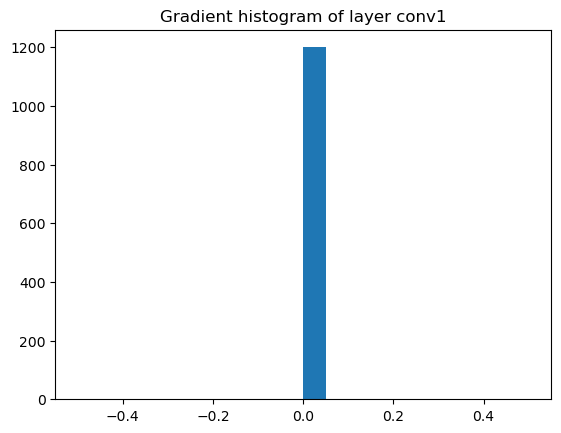

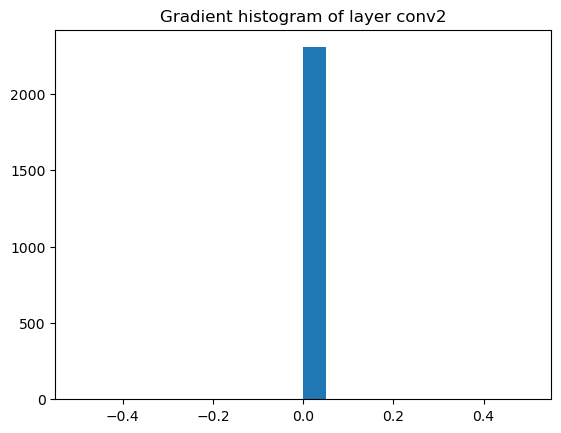

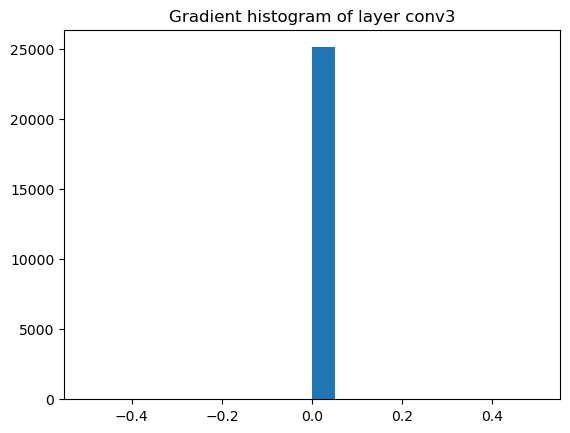

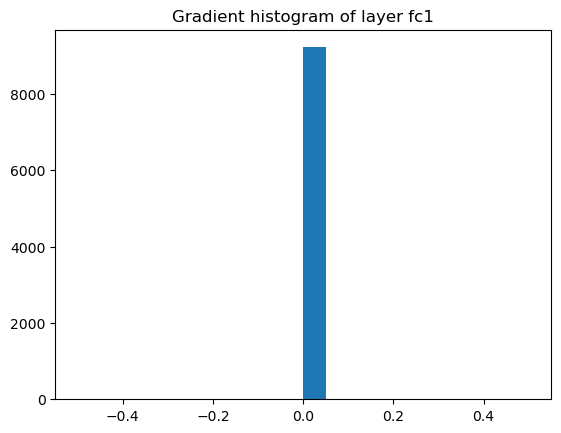

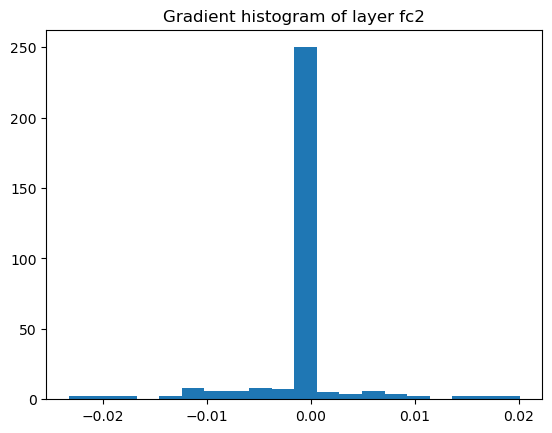

In [7]:
'''
Lab 3(c)
'''
# Set model weights to zero
for name, module in net.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        # Set the weight of each module to all zero
             #Your code here
        module.weight.data.zero_()

# Reset gradients
net.zero_grad()

# Forward and backward pass
# Random data and target
data = torch.randn(1,3,32,32).to(device)
target = torch.randn(1, 10).to(device)

# Forward pass
out = net(data)

# Loss computation
loss = criterion(out, target)
# Backward pass
loss.backward()

for name, module in net.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        # Get the gradient of the module as a NumPy array
        gradient = module.weight.grad.detach().cpu().numpy()     #Your code here

        # Reshape for histogram
        gradient = gradient.reshape(-1)
        _ = plt.hist(gradient, bins=20)
        plt.title("Gradient histogram of layer "+name)
        plt.show()